In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
# 加载Kaggle信用卡欺诈数据集（需提前下载）
df = pd.read_csv('creditcard_2023.csv')
amounts = df['Amount'].values  # 交易金额

df_health = pd.read_csv("healthcare_dataset.csv")
df_student = pd.read_csv("student_depression_dataset.csv")

# 真实最大值（用于后续对比）
true_max = amounts.max()
true_sum_a = amounts.sum()

Depression = df_student['Age'].astype(int)
true_sum_d = Depression.sum()

Health = df_health['Billing Amount'].astype(int)
true_sum_h = Health.sum()

In [15]:
def laplace_mechanism(data, U, epsilon):
    """Laplace机制：噪声尺度依赖 U"""
    scale = U / epsilon
    noise = np.random.laplace(0, scale)
    return np.sum(data) + noise

def sumdp(data, U, epsilon, delta=1e-5, beta=0.1):
    """SumDP算法（论文实现）"""
    n = len(data)
    logU =int(np.ceil(np.log(U)))  # 区间数量
    
    # 计算每个区间的真实和
    interval_snumber = np.zeros(int(logU))
    interval_sums = np.zeros(int(logU))
    for j in range(logU):
        lower = 1 if j == 0 else (2 ** (j-1)) + 1
        upper = 2 ** j
        mask = (data >= lower) & (data <= upper)
        interval_sums[j] = np.sum(data[mask])
        interval_snumber[j] = len(data[mask])
    
    # 添加Laplace噪声
    noisy_sums = np.zeros(logU)
    thresholds = np.zeros(logU)
    for j in range(logU):
        upper = 2 ** j
        scale = upper / epsilon
        noisy_sums[j] = interval_sums[j] + np.random.laplace(0, scale)
        thresholds[j] = 1.3 * upper * np.log((2 * (logU+1)) / beta) / epsilon 
    
    # 选择截断阈值 tau
    tau = 0
    for j in range(logU):
        if noisy_sums[j] > thresholds[j]:
            tau = 2 ** j
    
    # 聚合截断和
    clipped_sum = 0
    for j in range(logU):
        if 2**j<=tau:
            clipped_sum += noisy_sums[j]
        else:
            break
    
    return clipped_sum

In [16]:
def evaluate_U_impact(data, true_sum, true_max, epsilons=[1.0], U_values=None, trials=30):
    if U_values is None:
        U_values = [2 ** i for i in range(22, 30)]  # 测试 U=1024到1M
    
    results = []
    for U in U_values:
        # 标准化数据到 [0, U]
        #scaler = MinMaxScaler(feature_range=(0, U))
        #data_scaled = scaler.fit_transform(data.reshape(-1, 1)).flatten()
        data_scaled = data
        for epsilon in epsilons:
            laplace_errors = []
            sumdp_errors = []
            
            for _ in range(trials):
                # Laplace机制
                noisy_laplace = laplace_mechanism(data_scaled, U, epsilon)
                laplace_errors.append(abs(noisy_laplace - true_sum) / true_sum)
                #laplace_errors.append(abs(noisy_laplace - true_sum))
                # SumDP
                noisy_sumdp = sumdp(data_scaled, U, epsilon)
                sumdp_errors.append(abs(noisy_sumdp - true_sum) / true_sum)
                #sumdp_errors.append(abs(noisy_sumdp - true_sum))
            
            results.append({
                'U': U,
                'Epsilon': epsilon,
                'Laplace Error': np.mean(sorted(laplace_errors)[9:19]),
                'SumDP Error': np.mean(sorted(sumdp_errors)[9:19]),
                'U/Max(D)': U / true_max  # 显示U与真实最大值的比例
            })
    
    return pd.DataFrame(results)

# 运行实验
results_df_a = evaluate_U_impact(amounts, true_sum_a, true_max, epsilons=[1.0])


results_df_d = evaluate_U_impact(Depression, true_sum_d, true_max, epsilons=[1.0])

results_df_h = evaluate_U_impact(Health, true_sum_h, true_max, epsilons=[1.0])




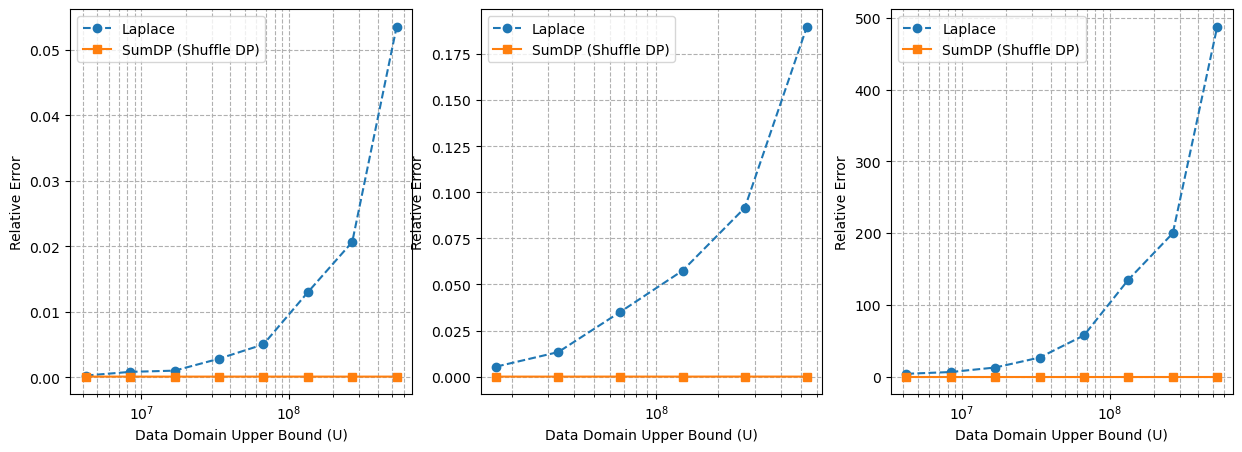

In [17]:
# 绘制误差随U的变化
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(results_df_a['U'], results_df_a['Laplace Error'], label='Laplace', marker='o', linestyle='--')
plt.plot(results_df_a['U'], results_df_a['SumDP Error'], label='SumDP (Shuffle DP)', marker='s', linestyle='-')
plt.xscale('log')  # 对数坐标，因为U是2的幂次
plt.xlabel('Data Domain Upper Bound (U)')
plt.ylabel('Relative Error')
#plt.title('Impact of U on Sum Aggregation Error (ε=1) on')
plt.legend()
plt.grid(True, which="both", ls="--")


plt.subplot(1, 3, 2)
plt.plot(results_df_h['U'][2:], results_df_h['Laplace Error'][2:], label='Laplace', marker='o', linestyle='--')
plt.plot(results_df_h['U'][2:], results_df_h['SumDP Error'][2:], label='SumDP (Shuffle DP)', marker='s', linestyle='-')
plt.xscale('log')  # 对数坐标，因为U是2的幂次
plt.xlabel('Data Domain Upper Bound (U)')
plt.ylabel('Relative Error')
#plt.title('Impact of U on Sum Aggregation Error (ε=1) on')
plt.legend()
plt.grid(True, which="both", ls="--")

plt.subplot(1, 3, 3)
plt.plot(results_df_d['U'], results_df_d['Laplace Error'], label='Laplace', marker='o', linestyle='--')
plt.plot(results_df_d['U'], results_df_d['SumDP Error'], label='SumDP (Shuffle DP)', marker='s', linestyle='-')
plt.xscale('log')  # 对数坐标，因为U是2的幂次
plt.xlabel('Data Domain Upper Bound (U)')
plt.ylabel('Relative Error')
#plt.title('Impact of U on Sum Aggregation Error (ε=1) on')
plt.legend()
plt.grid(True, which="both", ls="--")


plt.show()

In [33]:
U_fixed = 10000000
epsilons = [0.1, 0.5, 1.0, 2.0, 5.0]
results_epsilon_a = evaluate_U_impact(amounts, true_sum_a, true_max=1, epsilons=epsilons, U_values=[U_fixed])
results_epsilon_h = evaluate_U_impact(Health, true_sum_h, true_max=1, epsilons=epsilons, U_values=[U_fixed])
results_epsilon_d = evaluate_U_impact(Depression, true_sum_d, true_max=1, epsilons=epsilons, U_values=[U_fixed])



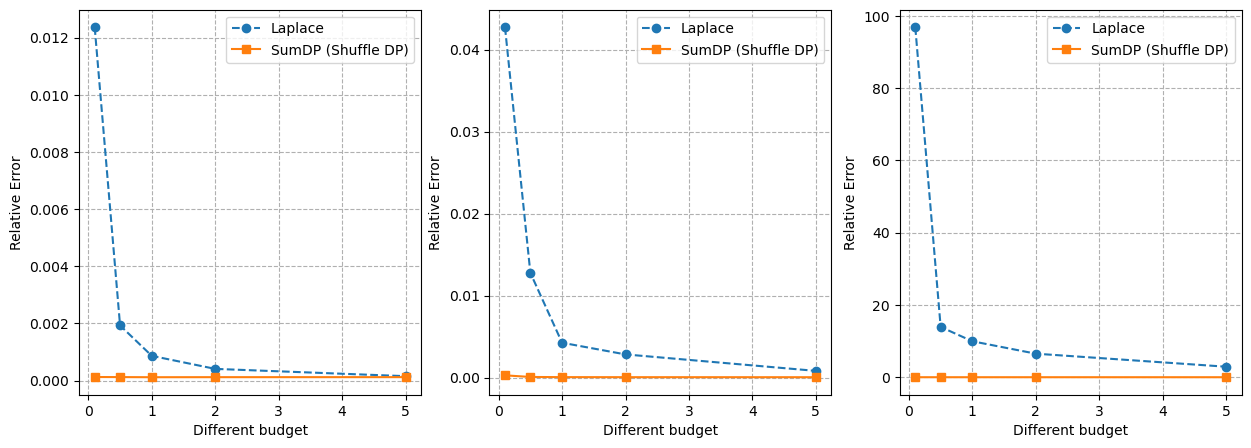

In [34]:

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(results_epsilon_a['Epsilon'], results_epsilon_a['Laplace Error'], label='Laplace', marker='o', linestyle='--')
plt.plot(results_epsilon_a['Epsilon'], results_epsilon_a['SumDP Error'], label='SumDP (Shuffle DP)', marker='s', linestyle='-')

plt.xlabel('Different budget')
plt.ylabel('Relative Error')
#plt.title('Impact of U on Sum Aggregation Error (ε=1) on')
plt.legend()
plt.grid(True, which="both", ls="--")


plt.subplot(1, 3, 2)
plt.plot(results_epsilon_h['Epsilon'], results_epsilon_h['Laplace Error'], label='Laplace', marker='o', linestyle='--')
plt.plot(results_epsilon_h['Epsilon'], results_epsilon_h['SumDP Error'], label='SumDP (Shuffle DP)', marker='s', linestyle='-')

plt.xlabel('Different budget')
plt.ylabel('Relative Error')
#plt.title('Impact of U on Sum Aggregation Error (ε=1) on')
plt.legend()
plt.grid(True, which="both", ls="--")

plt.subplot(1, 3, 3)
plt.plot(results_epsilon_d['Epsilon'], results_epsilon_d['Laplace Error'], label='Laplace', marker='o', linestyle='--')
plt.plot(results_epsilon_d['Epsilon'], results_epsilon_d['SumDP Error'], label='SumDP (Shuffle DP)', marker='s', linestyle='-')

plt.xlabel('Different budget')
plt.ylabel('Relative Error')
#plt.title('Impact of U on Sum Aggregation Error (ε=1) on')
plt.legend()
plt.grid(True, which="both", ls="--")

            U  Epsilon  Laplace Error  SumDP Error      U/Max(D)
0  1000000000      1.0       0.512258     0.000108  1.000000e+09
1  1000000000      1.0       0.311163     0.000117  1.000000e+09
2  1000000000      1.0       0.181210     0.000115  1.000000e+09
3  1000000000      1.0       0.099085     0.000133  1.000000e+09
4  1000000000      1.0       0.122108     0.000129  1.000000e+09


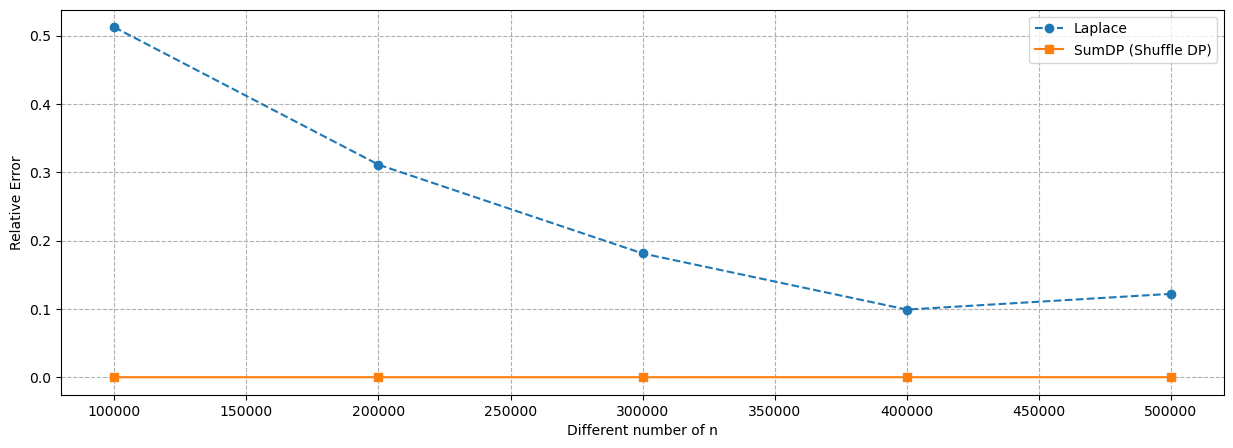

In [44]:
U_fixed = 10**9
epsilons = [1.0]

numbern=[100000,200000,300000,400000,500000]
result1=pd.DataFrame()
for i in numbern:
    results_epsilon_a = evaluate_U_impact(amounts[:i], true_sum=sum(amounts[:i]), true_max=1, epsilons=epsilons, U_values=[U_fixed])
    result1 = pd.concat([result1, results_epsilon_a], ignore_index=True)
print(result1)
plt.figure(figsize=(15, 5))
plt.plot(numbern, result1['Laplace Error'], label='Laplace', marker='o', linestyle='--')
plt.plot(numbern, result1['SumDP Error'], label='SumDP (Shuffle DP)', marker='s', linestyle='-')

plt.xlabel('Different number of n')
plt.ylabel('Relative Error')
#plt.title('Impact of U on Sum Aggregation Error (ε=1) on')
plt.legend()
plt.grid(True, which="both", ls="--")

In [45]:
len(Health)

55500

           U  Epsilon  Laplace Error  SumDP Error     U/Max(D)
0  100000000      1.0       0.293560     0.000252  100000000.0
1  100000000      1.0       0.121333     0.000102  100000000.0
2  100000000      1.0       0.083500     0.000072  100000000.0
3  100000000      1.0       0.056464     0.000051  100000000.0
4  100000000      1.0       0.052877     0.000054  100000000.0


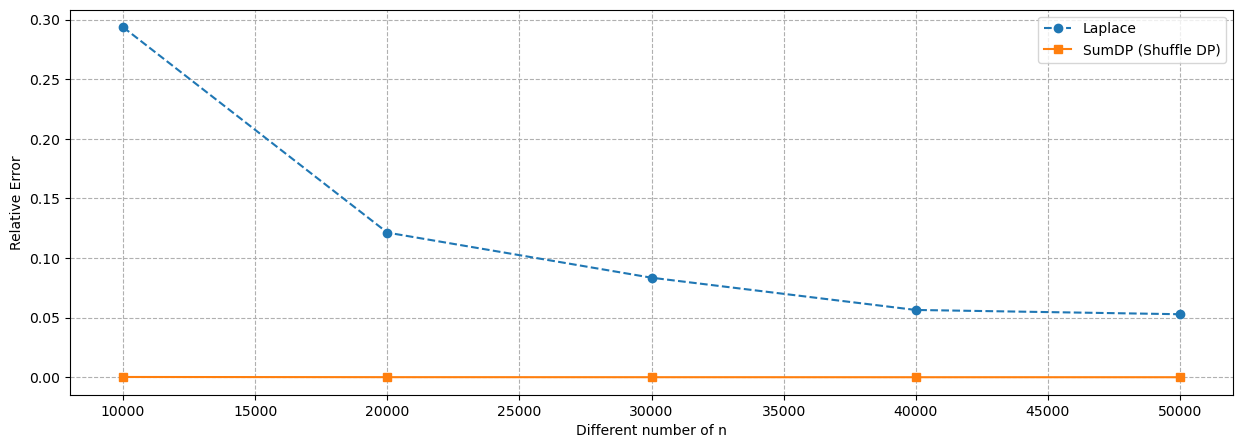

In [47]:
U_fixed = 10**8
epsilons = [1.0]

numbern=[10000,20000,30000,40000,50000]
result2=pd.DataFrame()
for i in numbern:
    results_epsilon_h = evaluate_U_impact(Health[:i], true_sum=sum(Health[:i]), true_max=1, epsilons=epsilons, U_values=[U_fixed])
    result2 = pd.concat([result2, results_epsilon_h], ignore_index=True)
print(result2)
plt.figure(figsize=(15, 5))
plt.plot(numbern, result2['Laplace Error'], label='Laplace', marker='o', linestyle='--')
plt.plot(numbern, result2['SumDP Error'], label='SumDP (Shuffle DP)', marker='s', linestyle='-')

plt.xlabel('Different number of n')
plt.ylabel('Relative Error')
#plt.title('Impact of U on Sum Aggregation Error (ε=1) on')
plt.legend()
plt.grid(True, which="both", ls="--")

In [48]:
len(Depression)

27901

        U  Epsilon  Laplace Error  SumDP Error  U/Max(D)
0  100000      1.0       0.453694     0.000379  100000.0
1  100000      1.0       0.206775     0.000200  100000.0
2  100000      1.0       0.184987     0.000182  100000.0
3  100000      1.0       0.172235     0.000108  100000.0
4  100000      1.0       0.144688     0.000071  100000.0


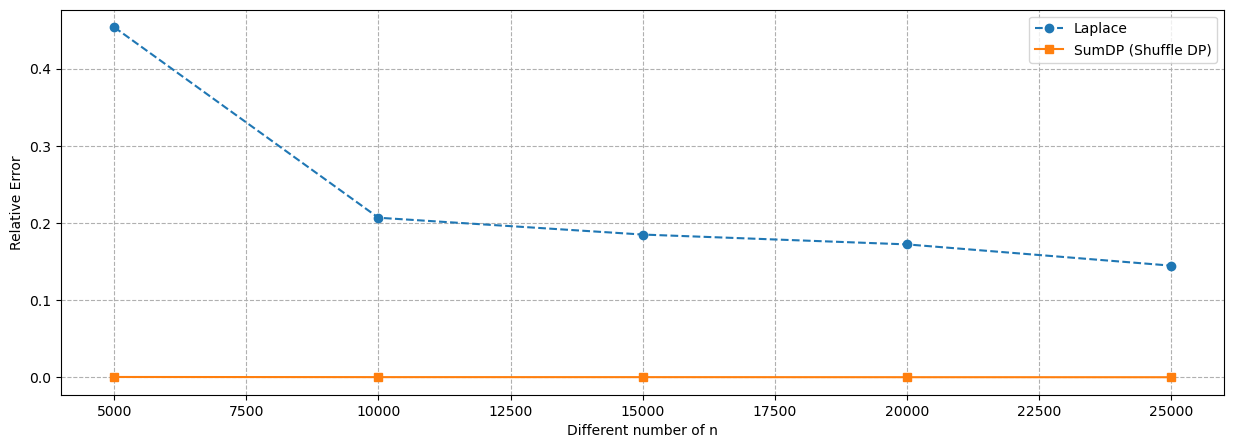

In [52]:
U_fixed = 10**5
epsilons = [1.0]

numbern=[5000,10000,15000,20000,25000]
result2=pd.DataFrame()
for i in numbern:
    results_epsilon_h = evaluate_U_impact(Depression[:i], true_sum=sum(Depression[:i]), true_max=1, epsilons=epsilons, U_values=[U_fixed])
    result2 = pd.concat([result2, results_epsilon_h], ignore_index=True)
print(result2)
plt.figure(figsize=(15, 5))
plt.plot(numbern, result2['Laplace Error'], label='Laplace', marker='o', linestyle='--')
plt.plot(numbern, result2['SumDP Error'], label='SumDP (Shuffle DP)', marker='s', linestyle='-')

plt.xlabel('Different number of n')
plt.ylabel('Relative Error')
#plt.title('Impact of U on Sum Aggregation Error (ε=1) on')
plt.legend()
plt.grid(True, which="both", ls="--")